# Data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, kruskal

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject').merge(df_metadata, on='PTID')
                                                                 
    # Remove sites that do not contain alzeihmers patient
    all_sites = set(df_full['SITEID'])
    ad_sites = set(df_full[df_full['DIAGNOSIS']==3.0]['SITEID'])
    missing_sites = [site for site in all_sites if site not in ad_sites]
    df_full = df_full[df_full['SITEID'].isin(missing_sites) == False]
    
    # Get back non-normalized (raw features)
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates
df_full

,Subject,PTID,Vscale,Brain_norm,GM_norm,WM_norm,vscf_norm,pgrey_norm,L_Thalmus,L_Caudate,L_Putamen,L_Palidum,Brainstem,L_Hippo,L_Amygdala,L_Accumbens,R_Thalmus,R_Caudate,R_Putamen,R_Palidum,R_Hippo,R_Amygdala,R_Accumbens,Thalmus,Caudate,Putamen,Palidum,Hippo,Amygdala,Accumbens,RID,SITEID,Phase,TYPE,VISIT,MAGSTRENGTH,SEQUENCE,SCANDATE,STUDYID,SERIESID,IMAGEUID,VISCODE,VISCODE2,DIAGNOSIS,DX_bl,AGE,PTGENDER,LASTEXAMDATE,LASTDIAGNOSIS,CONVERSOR,TYPECONVERSOR
0,sub001,002_S_0295,1.284262,1.125346e+06,566665.995583,558679.969095,62981.060530,452437.524288,6608.770424,3374.464075,4962.918287,1711.259076,21045.016060,3103.492474,921.036476,58.732761,6508.657764,3523.965647,5215.202191,1053.185188,2833.855708,556.626392,109.456509,13117.428188,6898.429722,10178.120478,2764.444264,5937.348182,1477.662868,168.189270,295,1,0,Original,ADNI2 Initial Visit-Cont Pt,3.0,MPRAGE SENSE2,2011-06-02,34310,110477,238628,v06,m60,1.0,CN,89.86502,1,2012-05-10,1.0,False,1.0
1,sub002,002_S_0413,1.317206,1.097888e+06,583891.242830,513996.489968,45375.432624,469556.901728,6913.182419,3183.591904,3424.791290,1533.596100,19737.549805,3277.191666,958.797562,227.999420,6493.183487,3569.990921,3782.390381,1371.596512,3393.591370,908.397690,205.199478,13406.365906,6753.582825,7207.181671,2905.192612,6670.783036,1867.195252,433.198898,413,1,0,Original,ADNI2 Initial Visit-Cont Pt,3.0,MPRAGE,2011-06-16,34751,111992,240812,v06,m60,1.0,CN,81.40609,0,2019-08-22,1.0,False,1.0
2,sub003,002_S_0685,1.347589,1.047523e+06,511314.040256,536209.033706,59649.832693,402216.261145,6959.832154,3310.391972,4541.110278,1413.590765,22486.638370,3176.908425,971.760224,355.066236,7017.230079,3543.988180,4618.530735,1099.904429,3347.767365,1222.709293,85.429470,13977.062233,6854.380152,9159.641013,2513.495194,6524.675790,2194.469517,440.495706,685,1,0,Original,ADNI2 Initial Visit-Cont Pt,3.0,MPRAGE SENSE2,2011-07-08,35323,114048,243903,v06,m60,1.0,CN,94.55825,0,2012-07-24,1.0,False,1.0
3,sub004,002_S_0729,1.504172,9.197952e+05,463393.651566,456401.504059,37447.435125,369460.880858,6188.384262,3220.791809,4501.188553,1586.395966,19583.950195,1894.795181,778.798019,284.399277,6364.783813,3542.390991,4239.589218,1453.196304,2149.194534,635.998383,153.599609,12553.168075,6763.182800,8740.777771,3039.592270,4043.989715,1414.796402,437.998886,729,1,0,Original,ADNI2 Initial Visit-Cont Pt,3.0,MPRAGE,2011-08-16,36869,119186,251177,v06,m60,3.0,LMCI,70.09932,0,2013-08-08,3.0,False,3.0
4,sub005,002_S_1155,1.344454,1.157368e+06,616084.539901,541283.251749,61859.791660,490519.977478,6931.182373,3887.990112,5282.386566,1501.196182,20501.947861,3449.991226,1075.197266,447.598862,6487.183502,4012.789795,5126.386963,1509.596161,4033.189743,973.197525,296.399246,13418.365875,7900.779907,10408.773529,3010.792343,7483.180969,2048.394791,743.998108,1155,1,0,Original,ADNI2 Initial Visit-Cont Pt,3.0,MPRAGE,2011-12-22,41151,134623,274154,v06,m60,2.0,LMCI,62.76646,1,2019-05-13,2.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,sub394,941_S_6581,1.138857,1.255128e+06,644535.086668,610592.681655,72728.247102,515410.816334,7123.000000,3500.000000,4199.000000,1852.000000,18873.000000,3421.000000,1148.000000,93.000000,7701.000000,3772.000000,4509.000000,1972.000000,3702.000000,1755.000000,293.000000,14824.000000,7272.000000,8708.000000,3824.000000,7123.000000,2903.000000,386.000000,6581,59,1,Original,ADNI Screening,3.0,Accelerated Sagittal MPRAGE,2018-09-12,126882,727038,1048378,sc,sc,1.0,SMC,74.40000,0,2020-12-22,1.0,False,1.0
709,sub395,941_S_6803,1.361559,1.016547e+06,495104.158718,521442.753529,59233.073495,392420.718521,5638.000000,2972.000000,4218.000000,1729.000000,20140.000000,2584.000000,1229.000000,258.000000,5773.000000,3046.000000,4261.000000,1477.000000,3187.000000,690.000000,165.000000,11411.000000,6018.000000,8479.000000,3206.000

### Site analysis

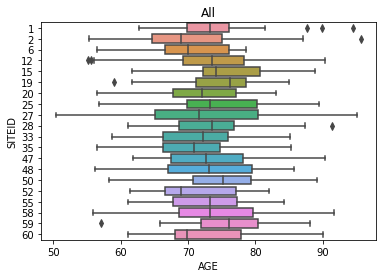

In [3]:
# Show age distribution by site
plt.figure()
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

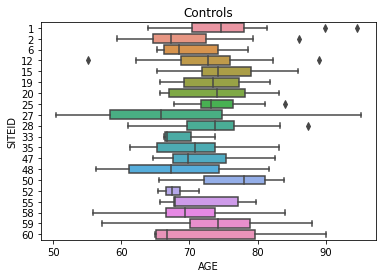

In [4]:
# Show age distribution by site
plt.figure()
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

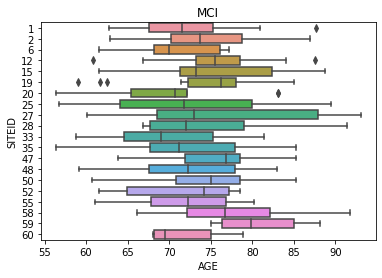

In [5]:
# Show age distribution by site
plt.figure()
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

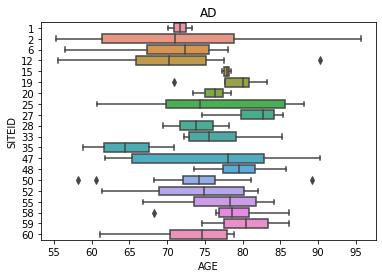

In [6]:
# Show age distribution by site
plt.figure()
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

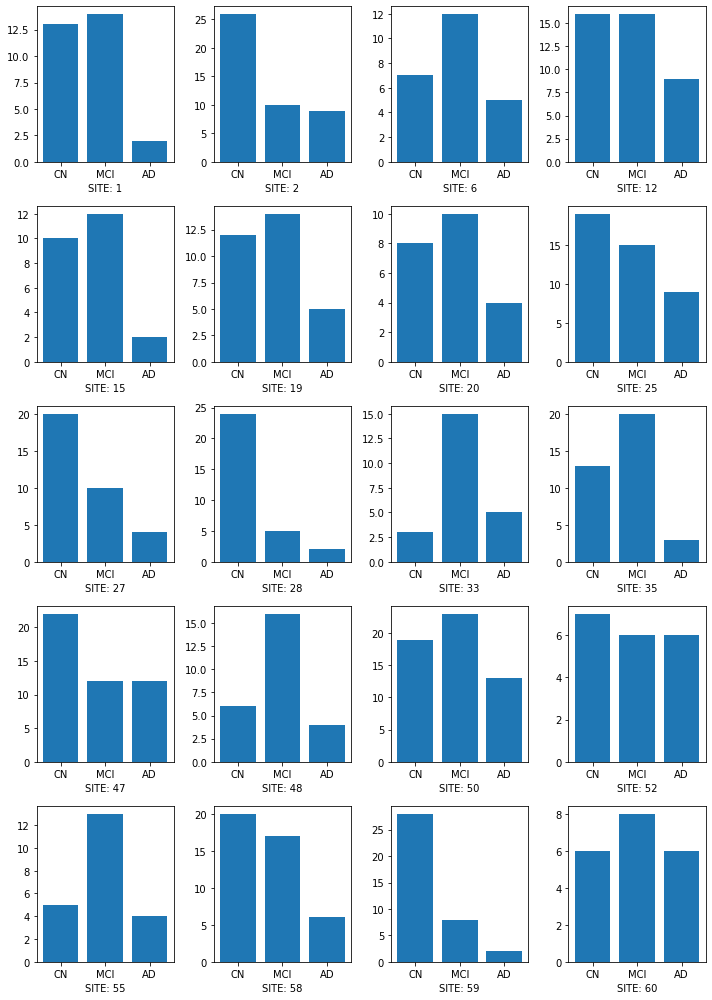

In [7]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,4,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

### Analysis on control

In [8]:
# Exctract controls that haven't converted
df_controls = df_full[df_full['TYPECONVERSOR']==1.0]

# Mark features to use
features = ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm', 'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']

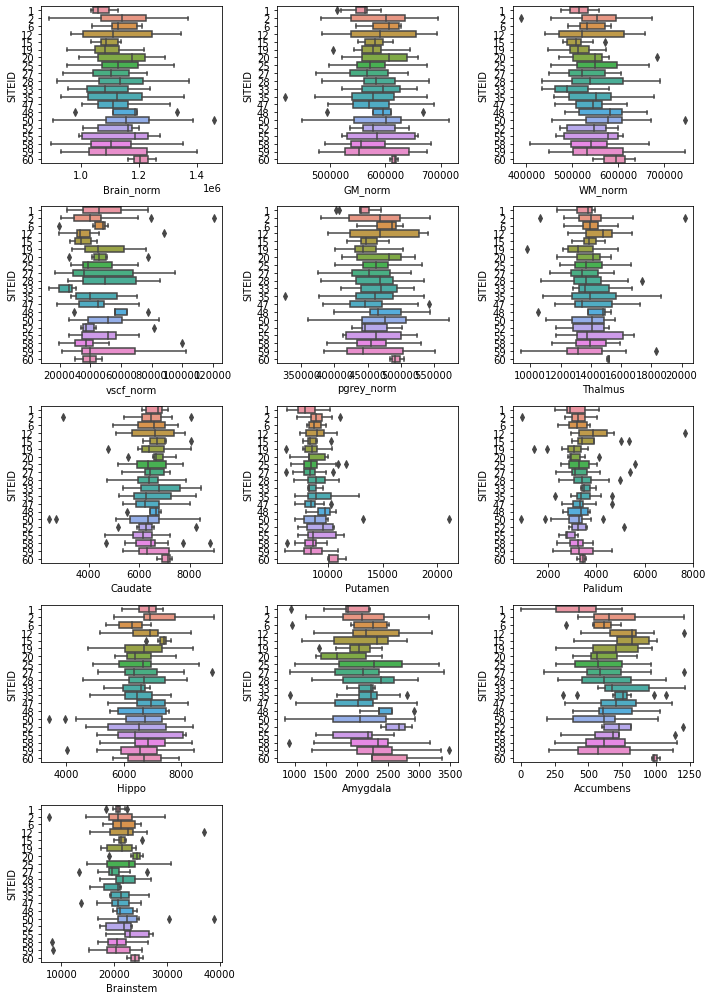

In [9]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_controls, orient='h')
    plt.tight_layout()

In [10]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_controls[features].to_numpy()
b = df_controls['SITEID'].to_numpy()
X = df_controls['AGE'].to_numpy()[:, np.newaxis]
C = df_controls[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

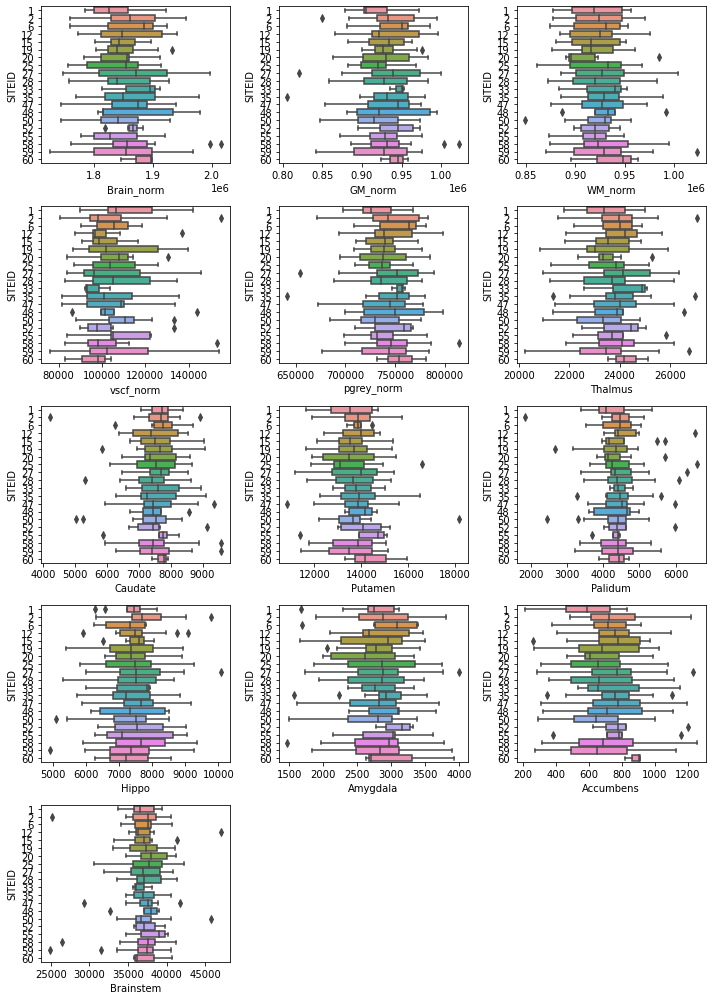

In [11]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_controls['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

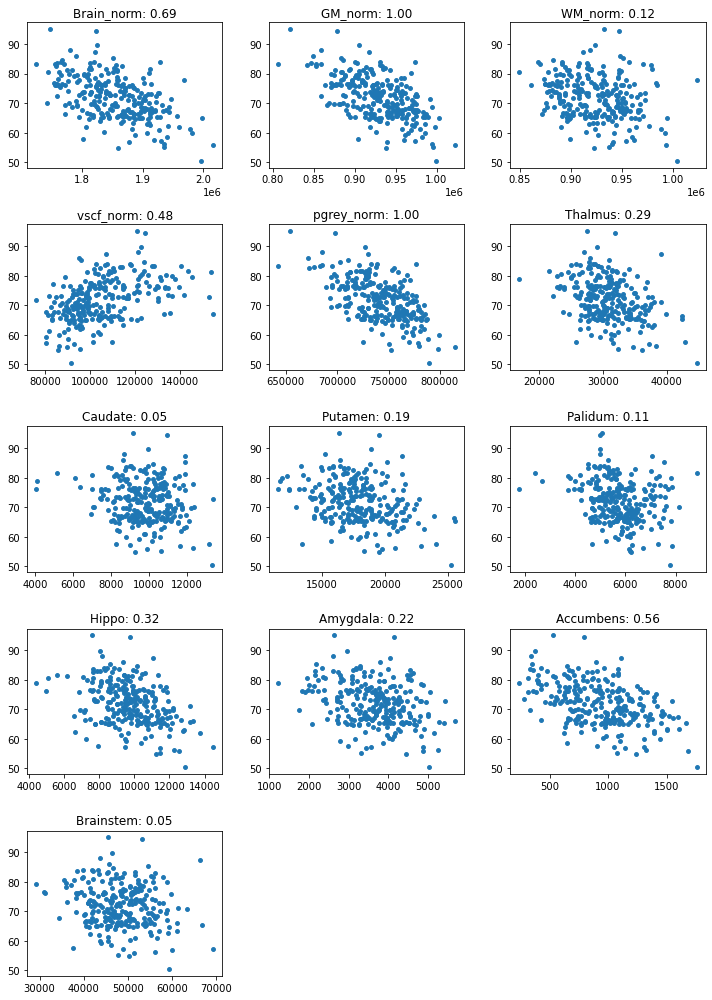

In [12]:
from sklearn.feature_selection import f_regression

X = df_features_harm[features].to_numpy()
Y = df_controls['AGE'].to_numpy()
# Normalize subcortical features by size of brain
vscale = df_controls['Vscale'].to_numpy()
X[:, 5:] = X[:, 5:]*vscale[:, None]

f_test, _ = f_regression(X, Y)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    plt.title("{0}: {1:.2f}".format(features[d],f_test[d]))
plt.tight_layout()

In [13]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 4.049203


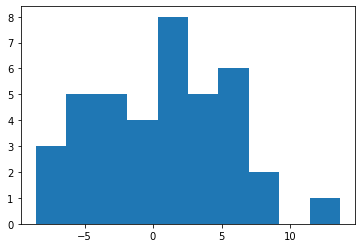

In [14]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression(fit_intercept='True')
# Train the model
LR.fit(X_train, Y_train)

# Compute the predictions over test data
f_test = LR.predict(X_test)
errors = Y_test-f_test
MAE_test = np.mean(np.abs(errors))
print('MAE in test: %f' % MAE_test)
plt.hist(errors)
plt.show()

### TODO

Create cross validation skeam y mirar lasso, ridge, y polynomial
Probar random forests

### Analysis of brain deltas

In [15]:
# Harmonize all data
Y = df_full[features].to_numpy()
b = df_full['SITEID'].to_numpy()
X = df_full['AGE'].to_numpy()[:, np.newaxis]
C = df_full[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.transform(Y=Y, b=b, X=X, C=C)
df_full['PredBrainAge'] = LR.predict(y_adjusted)
df_full['BrainDelta'] = df_full['PredBrainAge']-df_full['AGE']

Brain delta mean for
CN: 0.681019
MCI: 3.523466
AD: 7.314686
Brain delta median for
CN: 0.720254
MCI: 3.144493
AD: 6.308808
p-value
CN vs MCI: 0.017870
CN vs AD: 0.000041
MCI vs AD: 0.000029


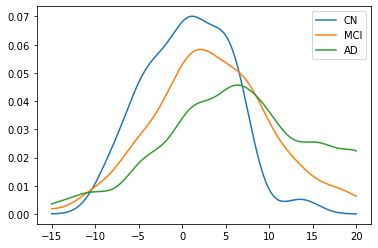

In [16]:
# Explore difference between CN, MCI and AD
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Make estimations
delta_brain_controls = errors
delta_brain_mci = df_mci['BrainDelta'].to_numpy()
delta_brain_ad = df_ad['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('MCI: %f' % np.mean(delta_brain_mci))
print('AD: %f' % np.mean(delta_brain_ad))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('MCI: %f' % np.median(delta_brain_mci))
print('AD: %f' % np.median(delta_brain_ad))

# Calculate p-value
print('p-value')
tstat_cnvsmci, pval_cnvsmci = ttest_ind(delta_brain_controls, delta_brain_mci)
tstat_cnvsad, pval_cnvsad = ttest_ind(delta_brain_controls, delta_brain_ad)
tstat_mcivsad, pval_mcivsad = ttest_ind(delta_brain_ad, delta_brain_mci)
print('CN vs MCI: %f' % pval_cnvsmci)
print('CN vs AD: %f' % pval_cnvsad)
print('MCI vs AD: %f' % pval_mcivsad)

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.legend()
plt.show()

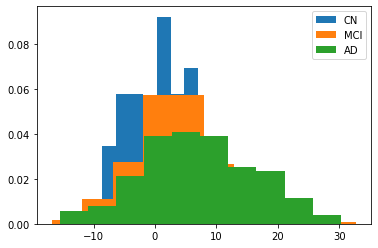

In [17]:
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_ad, label='AD', density=True)
plt.legend()
plt.show()

Brain delta mean for
CN: 0.681019
CN2MCI: 1.934873
Brain delta median for
CN: 0.720254
CN2MCI: 1.498846
p-value
MCI vs MCI2AD: 0.339667


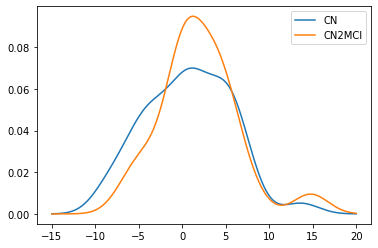

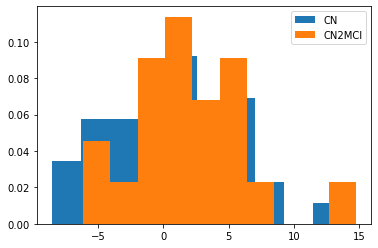

In [18]:
# Explore differences between CN and CN2MCI conversors
df_cn2mci = df_full[df_full['TYPECONVERSOR']==4.0]
delta_brain_cn2mci = df_cn2mci['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('CN2MCI: %f' % np.mean(delta_brain_cn2mci))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('CN2MCI: %f' % np.median(delta_brain_cn2mci))

# Calculate p-value
print('p-value')
tstat_cn2mci, pval_cn2mci = ttest_ind(delta_brain_controls, delta_brain_cn2mci)
print('MCI vs MCI2AD: %f' % pval_cn2mci)

# Plot kernel densities
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_cn2mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='CN2MCI')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_cn2mci, label='CN2MCI', density=True)
plt.legend()
plt.show()

Brain delta mean for
MCI: 2.906989
MCI2AD: 5.404005
Brain delta median for
MCI: 2.418326
MCI2AD: 4.260733
p-value
MCI vs MCI2AD: 0.016743


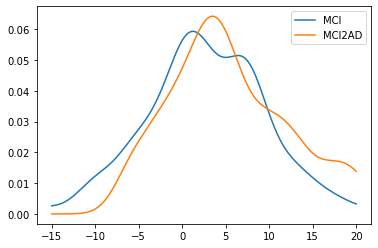

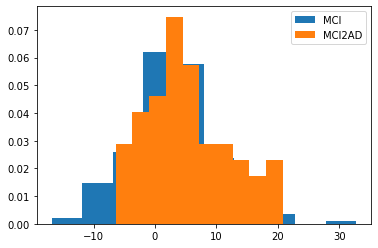

In [19]:
# Explore differences between MCI and CN2MCI conversors
df_mci = df_full[df_full['TYPECONVERSOR']==2.0]
df_mci2ad = df_full[df_full['TYPECONVERSOR']==5.0]
delta_brain_mci2ad = df_mci2ad['BrainDelta'].to_numpy()
delta_brain_mci = df_mci['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('MCI: %f' % np.mean(delta_brain_mci))
print('MCI2AD: %f' % np.mean(delta_brain_mci2ad))
print('Brain delta median for')
print('MCI: %f' % np.median(delta_brain_mci))
print('MCI2AD: %f' % np.median(delta_brain_mci2ad))

# Calculate t-test
print('p-value')
tstat_mci2ad, pval_mci2ad = ttest_ind(delta_brain_mci, delta_brain_mci2ad)
print('MCI vs MCI2AD: %f' % pval_mci2ad)

# Plot kernel density estimates
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci2ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
plt.legend()
plt.show()

# Plot histograms
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_mci2ad, label='MCI2AD', density=True)
plt.legend()
plt.show()